In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
with open('all_df.pkl', 'rb') as f:
    df = pickle.load(f)

### EDA

In [3]:
df.head(3)

,Land_Truth,Mean_Blue,Mean_Green,Mean_nDSM,Mean_NIR,Mean_Ratio,Mean_Red,NDVI,NIR_R_diff,sd_dsm
0,Healthy Grass,76.214724,100.404908,0.266467,157.196319,1.761515,89.239264,0.275760,67.957055,1.108161
1,Trees,60.936709,64.531646,6.674799,129.050633,2.449543,52.683544,0.420213,76.367089,2.821334
2,Pavement,146.045455,162.479339,0.005762,136.404959,0.781302,174.586777,-0.122774,-38.181818,0.012323


Text(0.5, 1.0, 'NDVI by Class')

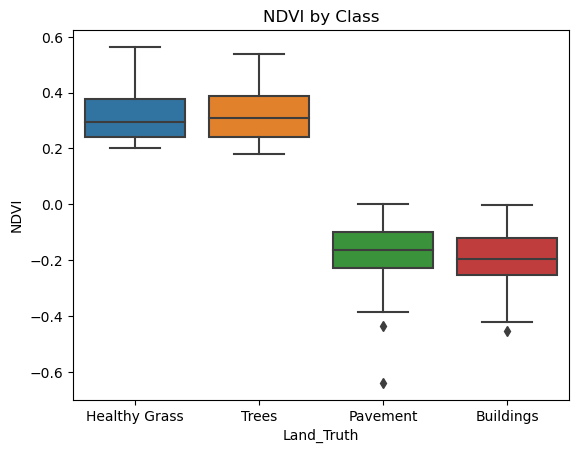

In [4]:
sns.boxplot(data=df, x='Land_Truth', y='NDVI')
plt.title('NDVI by Class')


Text(0.5, 1.0, 'Mean Blue by Class')

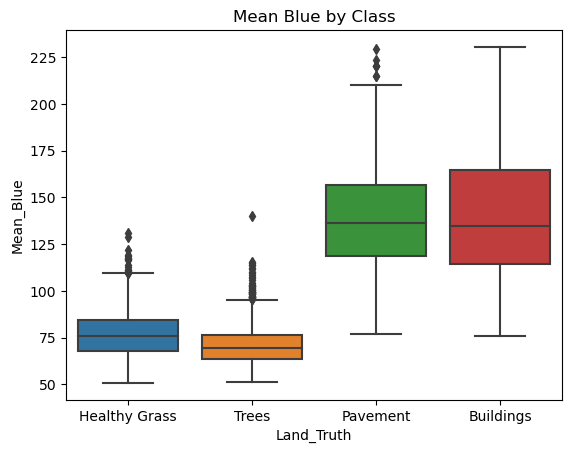

In [5]:
sns.boxplot(data=df, x='Land_Truth', y='Mean_Blue')
plt.title('Mean Blue by Class')

Text(0.5, 1.0, 'Height by Class')

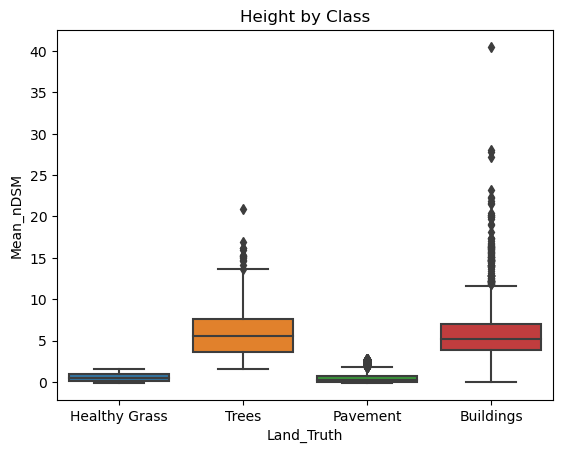

In [6]:
sns.boxplot(data=df, x='Land_Truth', y='Mean_nDSM')
plt.title('Height by Class')

In [7]:
df.columns

Index(['Land_Truth', 'Mean_Blue', 'Mean_Green', 'Mean_nDSM', 'Mean_NIR',
       'Mean_Ratio', 'Mean_Red', 'NDVI', 'NIR_R_diff', 'sd_dsm'],
      dtype='object')

Text(0.5, 1.0, 'NIR to Red Difference by Class')

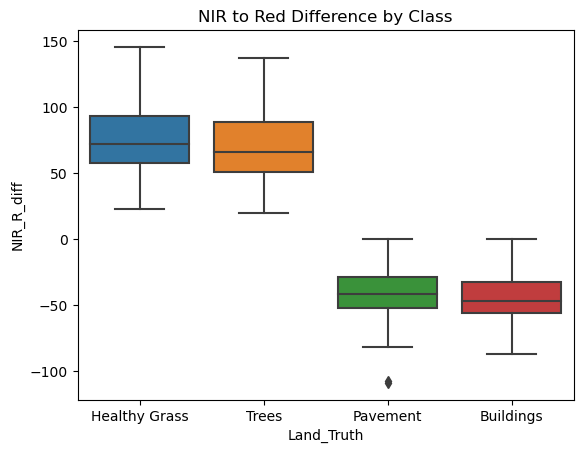

In [8]:
sns.boxplot(data=df, x='Land_Truth', y='NIR_R_diff')
plt.title('NIR to Red Difference by Class')

In [9]:
#sns.pairplot(df)

### Clean Data

In [10]:
# Trying limited features to test on the limited shadow dataframe. 
df = df[['Land_Truth', 'Mean_Red', 'Mean_NIR', 'Mean_nDSM', 'NDVI', 'sd_dsm']]
df = df[df['Land_Truth'] != 'Trees']

In [11]:
df['Land_Truth'].value_counts()

Healthy Grass    2000
Pavement         2000
Buildings        2000
Name: Land_Truth, dtype: int64

### Model Development: SVM

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df.drop('Land_Truth',axis=1) # features
y = df['Land_Truth'] # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # 70% of dataframe is for testing

In [14]:
# Training a support vector model
from sklearn.svm import SVC

In [15]:
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [16]:
predictions = svc.predict(X_test)

In [17]:
from sklearn.metrics import classification_report,confusion_matrix

In [18]:
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))

Confusion Matrix
[[521   0  72]
 [  0 599   0]
 [  1   0 607]]


In [19]:
print(classification_report(y_test,predictions))

               precision    recall  f1-score   support

    Buildings       1.00      0.88      0.93       593
Healthy Grass       1.00      1.00      1.00       599
     Pavement       0.89      1.00      0.94       608

     accuracy                           0.96      1800
    macro avg       0.96      0.96      0.96      1800
 weighted avg       0.96      0.96      0.96      1800



In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [22]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.9s
[CV] END .....................................C=0.1, gamma=1; total time=   2.3s
[CV] END .....................................C=0.1, gamma=1; total time=   2.0s
[CV] END .....................................C=0.1, gamma=1; total time=   1.7s
[CV] END .....................................C=0.1, gamma=1; total time=   2.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.7s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.5s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

In [23]:
grid_predictions = grid.predict(X_test)

In [24]:
print('Confusion Matrix')
print(confusion_matrix(y_test, grid_predictions))

Confusion Matrix
[[585   0   8]
 [  0 599   0]
 [ 14   0 594]]


In [25]:
print(classification_report(y_test, grid_predictions))

               precision    recall  f1-score   support

    Buildings       0.98      0.99      0.98       593
Healthy Grass       1.00      1.00      1.00       599
     Pavement       0.99      0.98      0.98       608

     accuracy                           0.99      1800
    macro avg       0.99      0.99      0.99      1800
 weighted avg       0.99      0.99      0.99      1800



In [26]:
grid.best_params_

{'C': 100, 'gamma': 0.001}

In [27]:
# save model
#with open('svm_C_100_gamma_001.pkl', 'wb') as f:
#    pickle.dump(grid, f)

In [28]:
# test grid model on a new input
sample = df[df['Land_Truth'] == 'Pavement'].sample(1)
sample

,Land_Truth,Mean_Red,Mean_NIR,Mean_nDSM,NDVI,sd_dsm
782,Pavement,158.714286,133.928571,2.016017,-0.084696,3.393536


In [29]:
sample_prediction = grid.predict(sample.drop('Land_Truth', axis=1))

In [30]:
sample_prediction

array(['Pavement'], dtype=object)

In [41]:
# run another prediction on a sample from the shadow dataframe
sd_sample = sd[sd['Land_Truth'] == 'Pavement'].sample(1)
sd_sample = sd_sample[['Land_Truth', 'Mean_Red', 'Mean_NIR', 'Mean_nDSM', 'NDVI', 'sd_dsm']]
sd_sample

,Land_Truth,Mean_Red,Mean_NIR,Mean_nDSM,NDVI,sd_dsm
220,Pavement,52.083333,35.75,0.61585,-0.185958,0.917936


In [42]:
sd_sample_prediction = grid.predict(sd_sample.drop('Land_Truth', axis=1))
sd_sample_prediction

array(['Healthy Grass'], dtype=object)

### Assessing model on Shadow Dataframe

In [1]:
# test on new ground truth samples
import geopandas as gpd


In [2]:
sd = gpd.read_file('West_reclass_sh.shp')

In [13]:
sd['Land_Truth'].value_counts()

Pavement        212
HealthyGrass     18
BareGrass        14
Buildings         6
Name: Land_Truth, dtype: int64

### Clean up shadow dataframe to match test data input features

In [4]:
sd = sd[sd['Land_Truth'] != 'BareGrass']
sd['Land_Truth'].value_counts()

Pavement        212
HealthyGrass     18
Buildings         6
Name: Land_Truth, dtype: int64

In [5]:
# clean up healthy grass in land truth
sd['Land_Truth'] = sd['Land_Truth'].apply(lambda x: x.replace('HealthyGrass', 'Healthy Grass') if x == 'HealthyGrass' else x)
sd['Land_Truth'].value_counts()

Pavement         212
Healthy Grass     18
Buildings          6
Name: Land_Truth, dtype: int64

In [6]:
sd.reset_index(inplace=True, drop=True)

### EDA on Shadow dataframe

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Red by Class')

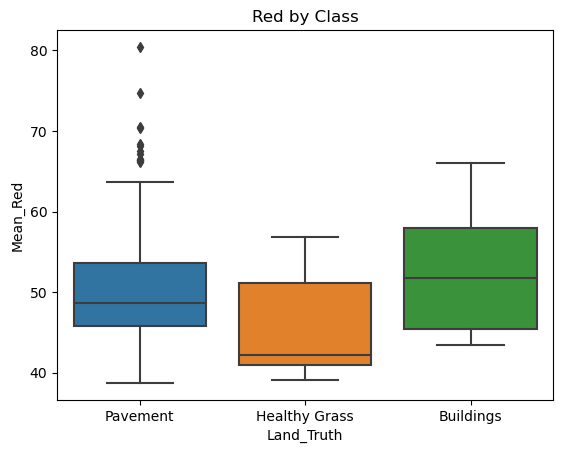

In [9]:
sns.boxplot(data=sd, x='Land_Truth', y='Mean_Red')
plt.title('Red by Class')


Text(0.5, 1.0, 'NIR by Class')

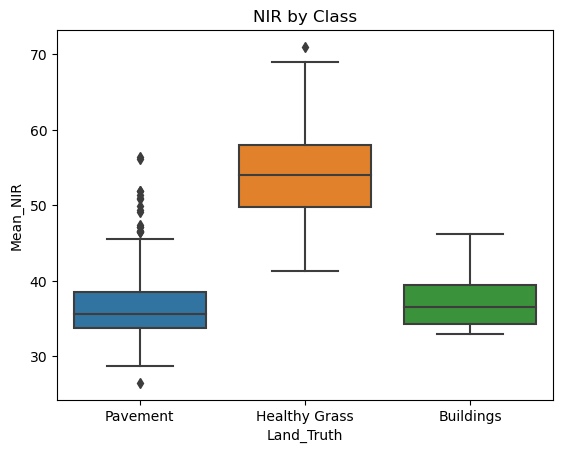

In [10]:
sns.boxplot(data=sd, x='Land_Truth', y='Mean_NIR')
plt.title('NIR by Class')


Text(0.5, 1.0, 'NIR_R_diff by Class')

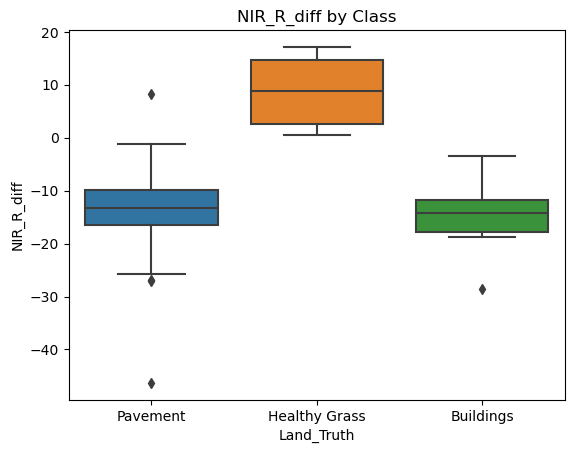

In [11]:
sns.boxplot(data=sd, x='Land_Truth', y='NIR_R_diff')
plt.title('NIR_R_diff by Class')


Text(0.5, 1.0, 'NDVI by Class')

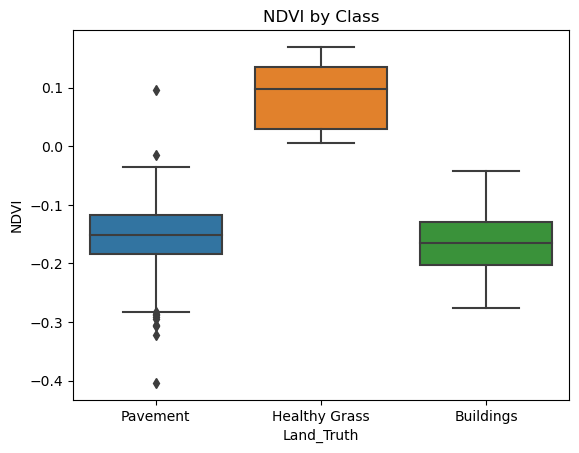

In [8]:
sns.boxplot(data=sd, x='Land_Truth', y='NDVI')
plt.title('NDVI by Class')


### Test model on shadow dataframe -- low performance

In [37]:
sd_feat = sd[['Mean_Red', 'Mean_NIR', 'Mean_nDSM', 'NDVI', 'sd_dsm']]
sd_feat.head()

,Mean_Red,Mean_NIR,Mean_nDSM,NDVI,sd_dsm
0,61.750000,46.625000,0.009974,-0.139562,0.030438
1,62.202247,43.831461,0.148366,-0.173254,0.735615
2,61.029126,44.601942,0.087949,-0.155515,0.574906
3,63.702703,44.045045,0.019740,-0.182441,0.044754
4,61.325581,45.534884,0.357567,-0.147769,1.171507


In [38]:
sd_labels = sd['Land_Truth']
sd_labels.head()

0    Pavement
1    Pavement
2    Pavement
3    Pavement
4    Pavement
Name: Land_Truth, dtype: object

In [39]:
sd_predictions = grid.predict(sd_feat)

In [40]:
print(classification_report(sd_labels, sd_predictions))

               precision    recall  f1-score   support

    Buildings       0.03      0.17      0.05         6
Healthy Grass       0.09      1.00      0.17        18
     Pavement       0.00      0.00      0.00       212

     accuracy                           0.08       236
    macro avg       0.04      0.39      0.07       236
 weighted avg       0.01      0.08      0.01       236



c:\Users\abreu\Anaconda3\envs\datasci\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abreu\Anaconda3\envs\datasci\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abreu\Anaconda3\envs\datasci\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
